In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.multiprocessing import Pool
import math
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Num_in=2#神经网络输入向量大小
Num=2*Num_in#路径长度
Epoch=40000 #迭代次数
N_samples=10000 #路径条数
m=1
a=0.1
omega=1
layer_num=2

#配分函数
N=Num
M=np.zeros([N,N])
for i in range(N):
    M[i][i]=a/2+1/a
for i in range(N-1):
    M[i][i+1]=-1/(2*a)
    M[i+1][i]=-1/(2*a)
    M[0][N-1]=-1/(2*a)
    M[N-1][0]=-1/(2*a)
M_det = np.linalg.det(M)
Z=(math.pi)**(N/2)/math.sqrt(M_det)
print(Z)

class flow_unit(nn.Module):
    def __init__(self,dim_channels,Numm) : 
        super().__init__()

        self.scale = nn.Sequential(
            nn.Linear(Numm, dim_channels),
            nn.ReLU(),
            nn.Linear(dim_channels, dim_channels),
            nn.ReLU(),
            nn.Linear(dim_channels,Numm),
            torch.nn.Tanh()
        )


        self.trans = nn.Sequential(
            nn.Linear(Numm, dim_channels),
            nn.ReLU(),
            nn.Linear(dim_channels, dim_channels),
            nn.ReLU(),
            nn.Linear(dim_channels, Numm),
            torch.nn.Tanh()
        )
        
    def forward(self,x,update_type):
        update=update_type%2
        x_update=x[:,update::2]#.unsqueeze(1)
        x_used=x[:,(1-update)::2]#.unsqueeze(1)
        scale=self.scale(x_used)
        trans=self.trans(x_used)
        x_update=x_update*torch.exp(scale)+trans
        
        y=torch.tensor(x)
        y[:,update::2]=x_update#.squeeze(1)
        y[:,(1-update)::2]=x_used#.squeeze(1)
        log_det =scale.sum(1)
        return y, log_det

#调整学习率
def lr_adjust(val_loss,optimizer):
    if(val_loss<0.1):
        for g in optimizer.param_groups:
            if(g['lr']>0.001):
                g['lr'] =0.0001
    if(val_loss<0.01):
        for g in optimizer.param_groups:
            if(g['lr']>0.001):
                g['lr'] =0.0001
                

# 创建流模型列表和优化器列表
flow_list = []
optim_list = []
loss_list=[]
lrs_list = []
for i in range(layer_num):  
    flow = flow_unit(dim_channels = 10,Numm=Num_in)
    optimizer = torch.optim.Adam(flow.parameters())
    flow_list.append(flow)
    optim_list.append(optimizer) 
    lrs=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.1,patience=10)
    lrs_list.append(lrs)
    
mean_squared_samples_list = []
for epoch in range(Epoch):
    samples0=torch.randn(size=[N_samples,Num])
    log_det=0
    samples=samples0
    
    for i in range(layer_num):
        samples,log_det0=flow_list[i](samples,i)
        log_det=log_det+log_det0
    #计算作用量
    energy = m * (((samples - torch.roll(samples, -1, dims = 1)).pow(2)).sum(1)) / (2 * a) + a * m * (omega**2) * (samples * samples).sum(1) / 2
    #计算损失函数
    loss = (-0.5 * (samples0 * samples0).sum(1) - log_det + energy+math.log(Z)-0.5*math.log(2*math.pi)).mean()
    for i in range(layer_num):
        optim_list[i].zero_grad()
    loss.backward()
    for i in range(layer_num):
        optim_list[i].step()
        lrs_list[i].step(loss)
    
    loss_list.append(loss.cpu().detach().numpy())
    
    mean_squared_samples = (samples * samples).mean().item()
    mean_squared_samples_list.append(mean_squared_samples)
plt.plot(range(Epoch), mean_squared_samples_list)
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Mean Squared Samples')
plt.title('Mean Squared Samples vs Epoch')
plt.show()

plt.plot(np.arange(np.array(loss_list).shape[0]),np.array(loss_list))
plt.yscale('log')
plt.show()

0.9808249233220863


C:\Users\Fish_Cat\AppData\Local\Temp\ipykernel_26444\3409098474.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(x)


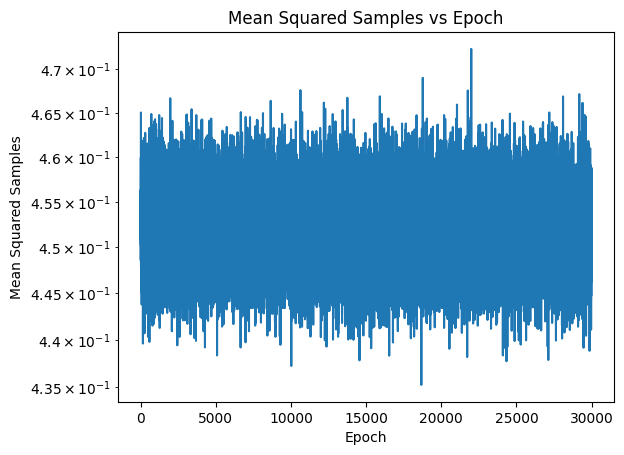

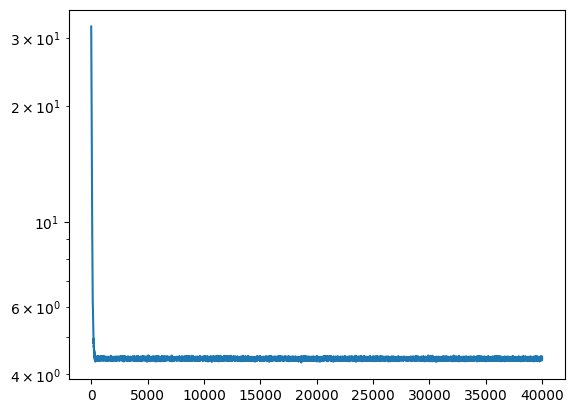

In [13]:
plt.plot(mean_squared_samples_list[10000:])
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Mean Squared Samples')
plt.title('Mean Squared Samples vs Epoch')
plt.show()

loss=np.array(loss_list)
plt.plot(loss)
plt.yscale('log')
plt.show()

In [14]:
print((samples*samples).mean())

tensor(0.4530, grad_fn=<MeanBackward0>)


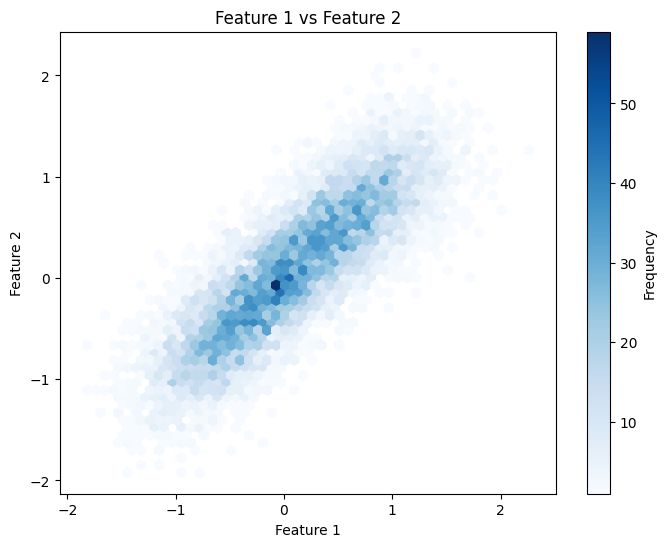

In [15]:
import seaborn as sns

def plot_feature_correlation(examples, i, j):
    # 确保索引有效
    if i >= examples.shape[1] or j >= examples.shape[1]:
        raise ValueError("Feature indices must be less than the number of features.")
    
    # 提取第i和j个特征
    feature_i = examples[:, i].cpu().numpy() if torch.is_tensor(examples) else examples[:, i]
    feature_j = examples[:, j].cpu().numpy() if torch.is_tensor(examples) else examples[:, j]

    # 绘图
    plt.figure(figsize=(8, 6))
    plt.hexbin(feature_i, feature_j, gridsize=50, cmap='Blues', mincnt=1)
    plt.colorbar(label='Frequency')
    plt.xlabel(f'Feature {i}')
    plt.ylabel(f'Feature {j}')
    plt.title(f'Feature {i} vs Feature {j}')
    plt.show()
samples_num=samples.detach().cpu().numpy()
plot_feature_correlation(samples_num, 1, 2)